### Machine learning model: Regression
##### Business goal: Create a model predicting the bike sharing demand
##### Data set: Capital bike rentals

In [331]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn import set_config
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [332]:
# Import and customize data

df_bikes=pd.read_csv('../data/train_bikes.csv', parse_dates=True, index_col=0)
df_bikes.drop(columns=['casual','registered'], inplace=True)
df_bikes['month'] = df_bikes.index.month
df_bikes['day'] = df_bikes.index.day
df_bikes['year'] = df_bikes.index.year
df_bikes['hour'] = df_bikes.index.hour
df_bikes['weekday'] = df_bikes.index.weekday

df_bikes.dropna(inplace=True)
df_bikes.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
month         0
day           0
year          0
hour          0
weekday       0
dtype: int64

In [333]:
# Convert season, weather to string
df_bikes['season'] = df_bikes['season'].replace({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
df_bikes['weather'] = df_bikes['weather'].replace({1: 'clear', 2: 'cloudy', 3: 'rainy', 4: 'storm'})
df_bikes["weather"].replace(to_replace="storm", value="rainy", inplace=True)
df_bikes['hour'] = df_bikes['hour'].replace({(23,0,1,2,3,4): 'night', (5,6,7,8,9,10): 'morning', (11,12,13,14,15,16): 'afternoon', (17,18,19,20,21,22): 'evening'})
df_bikes


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,year,hour,weekday
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,spring,0,0,clear,9.84,14.395,81,0.0000,16,1,1,2011,night,5
2011-01-01 01:00:00,spring,0,0,clear,9.02,13.635,80,0.0000,40,1,1,2011,night,5
2011-01-01 02:00:00,spring,0,0,clear,9.02,13.635,80,0.0000,32,1,1,2011,night,5
2011-01-01 03:00:00,spring,0,0,clear,9.84,14.395,75,0.0000,13,1,1,2011,night,5
2011-01-01 04:00:00,spring,0,0,clear,9.84,14.395,75,0.0000,1,1,1,2011,night,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,winter,0,1,clear,15.58,19.695,50,26.0027,336,12,19,2012,evening,2
2012-12-19 20:00:00,winter,0,1,clear,14.76,17.425,57,15.0013,241,12,19,2012,evening,2
2012-12-19 21:00:00,winter,0,1,clear,13.94,15.910,61,15.0013,168,12,19,2012,evening,2


In [334]:
# Train test split
y = df_bikes['count']
X = df_bikes.drop('count', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8708, 13), (2178, 13), (8708,), (2178,))

<AxesSubplot:>

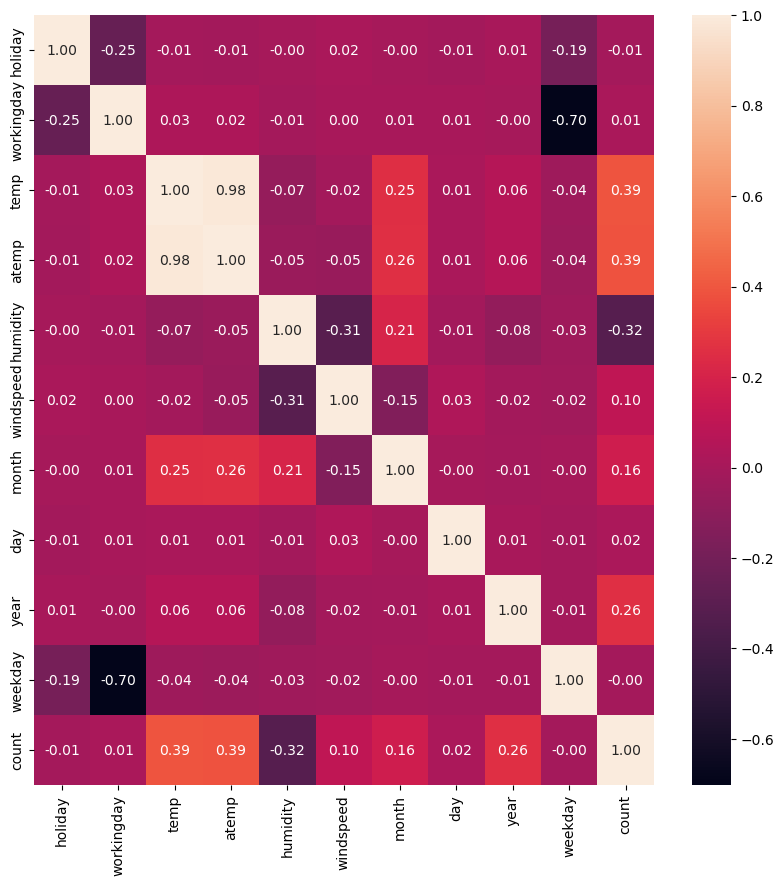

In [335]:
# Some more EDA
df_train = pd.concat([X_train, y_train], axis= 1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f")

##### Feature engineering

In [337]:
# Create pipelines

cat_pipe = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore'))

num_pipe = make_pipeline(
    MinMaxScaler())

time_pipe = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore'),
)




In [338]:
X_train['hour'].value_counts()

evening      2193
morning      2181
afternoon    2175
night        2159
Name: hour, dtype: int64

In [357]:
feature_transform = ColumnTransformer(transformers=
        [("cat", cat_pipe, ['weather', 'season', 'holiday', 'workingday']),
        ("num", num_pipe, ['temp', 'atemp', 'humidity', 'weekday']),
        ("time", time_pipe, ['hour', 'day', 'year', 'month']),
], 
)

In [358]:
final_pipe = make_pipeline(
    feature_transform, PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
)

In [359]:
set_config(display="diagram")
final_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['weather', 'season',
                                                   'holiday', 'workingday']),
                                                 ('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['temp', 'atemp', 'humidity',
                                                   'weekday']),
                                                 ('time',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['hour', 'day', 'year',
                                                   'month'])])),
                ('polynomialfeatures',
                 PolynomialFeatures(include_bias=False,
                                    interaction_only=True))])

In [360]:
# Generalized linear model with poisson distribution
# Supervised learning algorithm RandomForestRegressor

from sklearn.linear_model import PoissonRegressor
models = [
          ('poisson', PoissonRegressor()),
          ('forest', RandomForestRegressor())
]
m = VotingRegressor (models)

In [361]:
model_pipeline = make_pipeline(final_pipe, m)
model_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   ['weather',
                                                                    'season',
                                                                    'holiday',
                                                                    'workingday']),
                                                                  ('num',
                                                                   Pipeline(steps=[('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['temp',
                                                                    'atemp',
                                                                    'humidity',
                                                                    'weekday']),
                                                                  ('time',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   ['hour',
                                                                    'day',
                                                                    'year',
                                                                    'month'])])),
                                 ('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False,
                                                     interaction_only=True))])),
                ('votingregressor',
                 VotingRegressor(estimators=[('poisson', PoissonRegressor()),
                                             ('forest',
                                              RandomForestRegressor())]))])

In [362]:
# Validate model_pipeline with GridSearchCV

parameters = {'votingregressor__forest__n_estimators' : [2 ** i for i in range(3, 6)],  # parameters grid
              'votingregressor__forest__max_depth': [2, 4, 8, 16]
    

}

In [363]:
parameters

{'votingregressor__forest__n_estimators': [8, 16, 32],
 'votingregressor__forest__max_depth': [2, 4, 8, 16]}

In [392]:
grid_cv = GridSearchCV(estimator=model_pipeline, 
                    param_grid=parameters, 
                    cv=5, 
                    scoring='r2')

In [393]:
model_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'votingregressor', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__columntransformer', 'pipeline__polynomialfeatures', 'pipeline__columntransformer__n_jobs', 'pipeline__columntransformer__remainder', 'pipeline__columntransformer__sparse_threshold', 'pipeline__columntransformer__transformer_weights', 'pipeline__columntransformer__transformers', 'pipeline__columntransformer__verbose', 'pipeline__columntransformer__verbose_feature_names_out', 'pipeline__columntransformer__cat', 'pipeline__columntransformer__num', 'pipeline__columntransformer__time', 'pipeline__columntransformer__cat__memory', 'pipeline__columntransformer__cat__steps', 'pipeline__columntransformer__cat__verbose', 'pipeline__columntransformer__cat__onehotencoder', 'pipeline__columntransformer__cat__onehotencoder__categories', 'pipeline__columntransformer__cat__onehotencoder__drop', 'pipeline__columntransformer__cat__onehotencoder__dtype', 'pipeline_

In [394]:
grid_cv.fit(X_train, y_train)

/Users/lisakalfhues/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/lisakalfhues/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/lisakalfhues/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/lisakalfh

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('columntransformer',
                                                         ColumnTransformer(transformers=[('cat',
                                                                                          Pipeline(steps=[('onehotencoder',
                                                                                                           OneHotEncoder(handle_unknown='ignore',
                                                                                                                         sparse=False))]),
                                                                                          ['weather',
                                                                                           'season',
                                                                                           'holiday',
                                                                                           'workingday']),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('minmaxscaler',
                                                                                                           MinMaxScaler())]),
                                                                                          ['temp',
                                                                                           'atemp',
                                                                                           'humidity',
                                                                                           '...
                                                                                           'day',
                                                                                           'year',
                                                                                           'month'])])),
                                                        ('polynomialfeatures',
                                                         PolynomialFeatures(include_bias=False,
                                                                            interaction_only=True))])),
                                       ('votingregressor',
                                        VotingRegressor(estimators=[('poisson',
                                                                     PoissonRegressor()),
                                                                    ('forest',
                                                                     RandomForestRegressor())]))]),
             param_grid={'votingregressor__forest__max_depth': [2, 4, 8, 16],
                         'votingregressor__forest__n_estimators': [8, 16, 32]},
             scoring='r2')

In [395]:
def print_results(results):
    print('BEST MODEL PARAMETERS: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    for mean, params in zip(means, results.cv_results_['params']):
        print('{}  for {}'.format(round(mean, 4), params))

In [396]:
print_results(grid_cv)

BEST MODEL PARAMETERS: {'votingregressor__forest__max_depth': 16, 'votingregressor__forest__n_estimators': 32}

0.5951  for {'votingregressor__forest__max_depth': 2, 'votingregressor__forest__n_estimators': 8}
0.596  for {'votingregressor__forest__max_depth': 2, 'votingregressor__forest__n_estimators': 16}
0.5953  for {'votingregressor__forest__max_depth': 2, 'votingregressor__forest__n_estimators': 32}
0.6405  for {'votingregressor__forest__max_depth': 4, 'votingregressor__forest__n_estimators': 8}
0.6406  for {'votingregressor__forest__max_depth': 4, 'votingregressor__forest__n_estimators': 16}
0.6411  for {'votingregressor__forest__max_depth': 4, 'votingregressor__forest__n_estimators': 32}
0.6693  for {'votingregressor__forest__max_depth': 8, 'votingregressor__forest__n_estimators': 8}
0.6699  for {'votingregressor__forest__max_depth': 8, 'votingregressor__forest__n_estimators': 16}
0.6714  for {'votingregressor__forest__max_depth': 8, 'votingregressor__forest__n_estimators': 32}
0

In [397]:
# Get the best hyperparameters
grid_cv.best_params_

{'votingregressor__forest__max_depth': 16,
 'votingregressor__forest__n_estimators': 32}

In [398]:
results = pd.DataFrame(grid_cv.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_votingregressor__forest__max_depth,param_votingregressor__forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.064595,0.074875,0.017908,0.001714,2,8,"{'votingregressor__forest__max_depth': 2, 'vot...",0.594645,0.589690,0.595346,0.591732,0.604105,0.595104,0.004939,12
1,1.622017,0.154182,0.018644,0.003505,2,16,"{'votingregressor__forest__max_depth': 2, 'vot...",0.594771,0.588260,0.597116,0.594232,0.605415,0.595959,0.005558,10
2,2.530980,0.140183,0.018794,0.001274,2,32,"{'votingregressor__forest__max_depth': 2, 'vot...",0.594194,0.588168,0.596066,0.592597,0.605439,0.595293,0.005706,11
3,1.426079,0.060019,0.017373,0.002808,4,8,"{'votingregressor__forest__max_depth': 4, 'vot...",0.638449,0.648192,0.640266,0.638642,0.636883,0.640486,0.003999,9
4,2.151482,0.042670,0.018178,0.002172,4,16,"{'votingregressor__forest__max_depth': 4, 'vot...",0.638705,0.647397,0.643157,0.635724,0.637811,0.640559,0.004192,8


In [399]:
rf_best = grid_cv.best_estimator_
rf_best.fit_transform(X_train,y_train)

/Users/lisakalfhues/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/lisakalfhues/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/lisakalfhues/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


array([[163.35514518, 117.36435799],
       [641.53576054, 465.72449846],
       [249.26230093, 290.18216039],
       ...,
       [249.23447882, 229.06003951],
       [ 68.56062848,  36.9323988 ],
       [278.57554044, 274.34604801]])

In [400]:
# Train model with best parameters

rf_best.score(X_test, y_test)

0.7039207170994578

In [401]:
y_pred = rf_best.predict(X_test)
y_pred

array([182.44546762,  59.26543207, 119.47512813, ..., 459.26207384,
        53.70751031, 209.9866562 ])

In [419]:
# Upload kaggle data to run model on test data from kaggle 

test_kaggle=pd.read_csv('../data/test_kaggle.csv', parse_dates=True, index_col=0)
test_kaggle['month'] = test_kaggle.index.month
test_kaggle['day'] = test_kaggle.index.day
test_kaggle['year'] = test_kaggle.index.year
test_kaggle['hour'] = test_kaggle.index.hour
test_kaggle['weekday'] = test_kaggle.index.weekday
test_kaggle['season'] = test_kaggle['season'].replace({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
test_kaggle['weather'] = test_kaggle['weather'].replace({1: 'clear', 2: 'cloudy', 3: 'rainy', 4: 'storm'})
test_kaggle["weather"].replace(to_replace="storm", value="rainy", inplace=True)
test_kaggle['hour'] = test_kaggle['hour'].replace({(23,0,1,2,3,4): 'night', (5,6,7,8,9,10): 'morning', (11,12,13,14,15,16): 'afternoon', (17,18,19,20,21,22): 'evening'})
test_kaggle

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,year,hour,weekday
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,spring,0,1,clear,10.66,11.365,56,26.0027,1,20,2011,night,3
2011-01-20 01:00:00,spring,0,1,clear,10.66,13.635,56,0.0000,1,20,2011,night,3
2011-01-20 02:00:00,spring,0,1,clear,10.66,13.635,56,0.0000,1,20,2011,night,3
2011-01-20 03:00:00,spring,0,1,clear,10.66,12.880,56,11.0014,1,20,2011,night,3
2011-01-20 04:00:00,spring,0,1,clear,10.66,12.880,56,11.0014,1,20,2011,night,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,spring,0,1,cloudy,10.66,12.880,60,11.0014,12,31,2012,evening,0
2012-12-31 20:00:00,spring,0,1,cloudy,10.66,12.880,60,11.0014,12,31,2012,evening,0
2012-12-31 21:00:00,spring,0,1,clear,10.66,12.880,60,11.0014,12,31,2012,evening,0


In [420]:
y_pred_kaggle = rf_best.transform(test_kaggle)
test_kaggle.reset_index(inplace=True)
test_kaggle

In [422]:
y_pred_kaggle = rf_best.predict(test_kaggle)
y_pred_kaggle

array([ 13.29969017,  14.33163082,  14.33163082, ..., 176.15763816,
       183.1930146 ,  18.79587144])

In [423]:
# Create a csv. file with predictions

pred_kaggle=pd.DataFrame({'datetime':test_kaggle['datetime'],'count':y_pred_kaggle[0:]})
pred_kaggle

,datetime,count
0,2011-01-20 00:00:00,13.299690
1,2011-01-20 01:00:00,14.331631
2,2011-01-20 02:00:00,14.331631
3,2011-01-20 03:00:00,14.148305
4,2011-01-20 04:00:00,14.148305
...,...,...
6488,2012-12-31 19:00:00,194.108703
6489,2012-12-31 20:00:00,194.108703
6490,2012-12-31 21:00:00,176.157638
6491,2012-12-31 22:00:00,183.193015


In [424]:
pred_kaggle.to_csv('Submission_bike_rental.csv',index=False)